In [2]:


import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

 

/kaggle/input/marsproject/sorted/03-02-01-01-02-02-24.wav
/kaggle/input/marsproject/sorted/03-02-05-02-01-01-02.wav
/kaggle/input/marsproject/sorted/03-01-03-01-01-01-18.wav
/kaggle/input/marsproject/sorted/03-02-06-01-02-02-02.wav
/kaggle/input/marsproject/sorted/03-02-06-01-02-01-01.wav
/kaggle/input/marsproject/sorted/03-01-05-01-01-02-03.wav
/kaggle/input/marsproject/sorted/03-02-02-02-02-02-12.wav
/kaggle/input/marsproject/sorted/03-02-03-02-01-02-24.wav
/kaggle/input/marsproject/sorted/03-02-02-02-01-02-21.wav
/kaggle/input/marsproject/sorted/03-02-05-01-02-01-13.wav
/kaggle/input/marsproject/sorted/03-01-06-02-01-01-07.wav
/kaggle/input/marsproject/sorted/03-02-02-02-02-01-06.wav
/kaggle/input/marsproject/sorted/03-02-02-01-01-02-23.wav
/kaggle/input/marsproject/sorted/03-02-05-02-01-02-15.wav
/kaggle/input/marsproject/sorted/03-02-05-01-01-02-05.wav
/kaggle/input/marsproject/sorted/03-01-02-01-02-02-01.wav
/kaggle/input/marsproject/sorted/03-01-08-01-01-01-03.wav
/kaggle/input/

In [3]:
# 1️⃣ Install required packages
!pip install librosa --upgrade
!pip install resampy --upgrade
!pip install xgboost --upgrade

# 2️⃣ IMPORTS
import os
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
import xgboost as xgb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 5.8 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3


In [4]:
# 3️⃣ PATH TO YOUR FILES
root_dir = '/kaggle/input/marsproject/sorted'

# 4️⃣ LIST WAV FILES
files = [f for f in os.listdir(root_dir) if f.endswith('.wav')]
print(f'Found {len(files)} wav files')


Found 1112 wav files


In [5]:
# 5️⃣ EXTRACT MFCC FEATURES

def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    return mfccs_scaled

# 6️⃣ BUILD FEATURE + LABEL LISTS
X = []
Y = []

for file in tqdm(files):
    try:
        feature = extract_features(os.path.join(root_dir, file))
        X.append(feature)
        
        # Example label: use the 3rd part of filename (change if needed)
        label = file.split('-')[2]  # e.g., '03-02-01-01-02-02-24.wav' → '01'
        Y.append(label)
        
    except Exception as e:
        print(f'Error processing {file}: {e}')


100%|██████████| 1112/1112 [01:53<00:00,  9.77it/s]


In [6]:
# 7️⃣ ENCODE LABELS
le = LabelEncoder()
y_encoded = le.fit_transform(Y)

print(f'Classes: {le.classes_}')
print(f'X shape: {np.array(X).shape}')
print(f'y shape: {y_encoded.shape}')


Classes: ['01' '02' '03' '04' '05' '06' '07' '08']
X shape: (1112, 40)
y shape: (1112,)


In [7]:
# 8️⃣ SPLIT TRAIN/TEST
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y_encoded, test_size=0.2, random_state=42)

print(f'Train shape: {X_train.shape}')
print(f'Test shape: {X_test.shape}')


Train shape: (889, 40)
Test shape: (223, 40)


In [8]:
# 9️⃣ TRAIN XGBOOST
clf = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

clf.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [9]:
# 🔟 EVALUATE
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'XGBoost Test Accuracy: {acc:.3f}')
print(f'XGBoost F1 Score (weighted): {f1:.3f}')


XGBoost Test Accuracy: 0.776
XGBoost F1 Score (weighted): 0.771


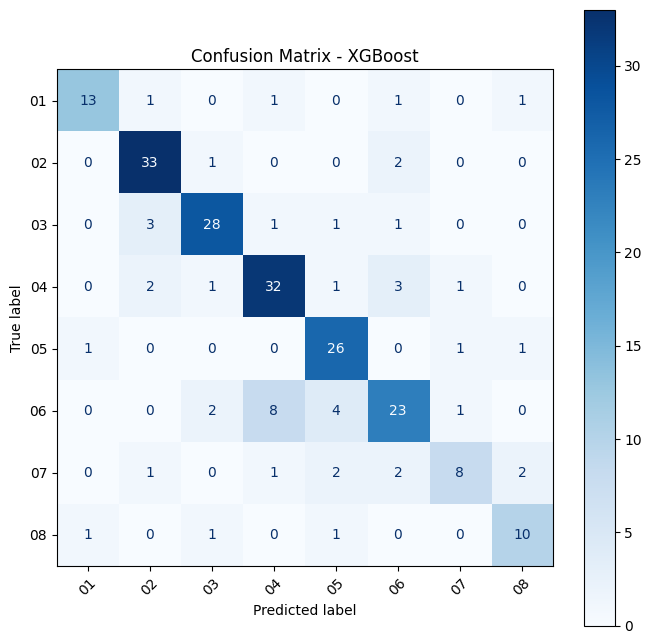

In [10]:
# CONFUSION MATRIX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [11]:
# Accuracy & F1 (already done)
y_pred = clf.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc:.4f}\n')

# CLASSIFICATION REPORT (like your example)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.7758

Classification Report:
              precision    recall  f1-score   support

          01       0.87      0.76      0.81        17
          02       0.82      0.92      0.87        36
          03       0.85      0.82      0.84        34
          04       0.74      0.80      0.77        40
          05       0.74      0.90      0.81        29
          06       0.72      0.61      0.66        38
          07       0.73      0.50      0.59        16
          08       0.71      0.77      0.74        13

    accuracy                           0.78       223
   macro avg       0.77      0.76      0.76       223
weighted avg       0.78      0.78      0.77       223



In [17]:
# Step 1: create folders
!mkdir -p emotion-audio-recognition/notebook
!mkdir -p emotion-audio-recognition/models
!mkdir -p emotion-audio-recognition/src

# Step 2: create empty files
!touch emotion-audio-recognition/README.md
!touch emotion-audio-recognition/requirements.txt


In [23]:
# Copy your notebook into project folder
!cp /kaggle/working/*.ipynb emotion-audio-recognition/notebook/emotion_recognition_xgboost.ipynb


cp: cannot stat '/kaggle/working/*.ipynb': No such file or directory


In [22]:
!cp /kaggle/working/*.ipynb emotion-audio-recognition/notebook/emotion_recognition_xgboost.ipynb


cp: cannot stat '/kaggle/working/*.ipynb': No such file or directory


In [24]:
# Copy your notebook into project folder
!cp /kaggle/working/*.ipynb emotion-audio-recognition/notebook/emotion_recognition_xgboost.ipynb


cp: cannot stat '/kaggle/working/*.ipynb': No such file or directory


In [25]:
!cp /kaggle/working/__notebook__.ipynb emotion-audio-recognition/notebook/emotion_recognition_xgboost.ipynb


cp: cannot stat '/kaggle/working/__notebook__.ipynb': No such file or directory
